# bunching estimation using the real data

take concept from simulation

In [1]:
# load packages

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from scipy.optimize import fsolve
from scipy import integrate
from sympy import symbols
import tools # this imports the file tools.py // must be in the same folder as the current file


In [2]:
# define parameters
pi = 250
phi = 50
phi120 = 100

In [3]:
# load data
wd = Path.cwd()
file = 'stata/Outages_{period}.dta'
data = pd.read_stata(wd.parent/file)
#print(data.columns)

# keep relevant columns
data = data[['date', 'duration_minutes', 'discom', 'planned']]
data['year'] = data.apply(lambda row: row.date.year, axis=1)

# keep year 2019
data = data[data.apply(lambda row: row.date.year == 2019, axis=1)]

# keep only unplanned
data = data.loc[data.planned != 'planned',]


# keep one firm
#data = data.loc[data.discom == 'tata',]
data

,date,duration_minutes,discom,planned,year
0,2019-12-02,43.0,brpl,0.0,2019.0
1,2019-12-03,9.0,brpl,0.0,2019.0
2,2019-12-05,57.0,brpl,0.0,2019.0
3,2019-12-06,37.0,brpl,0.0,2019.0
4,2019-12-06,33.0,brpl,0.0,2019.0
...,...,...,...,...,...
132655,2019-11-29,29.0,tata,0.0,2019.0
132662,2019-11-30,45.0,tata,0.0,2019.0
132663,2019-11-30,54.0,tata,0.0,2019.0
132664,2019-11-30,55.0,tata,0.0,2019.0


(0.0, 420.0)

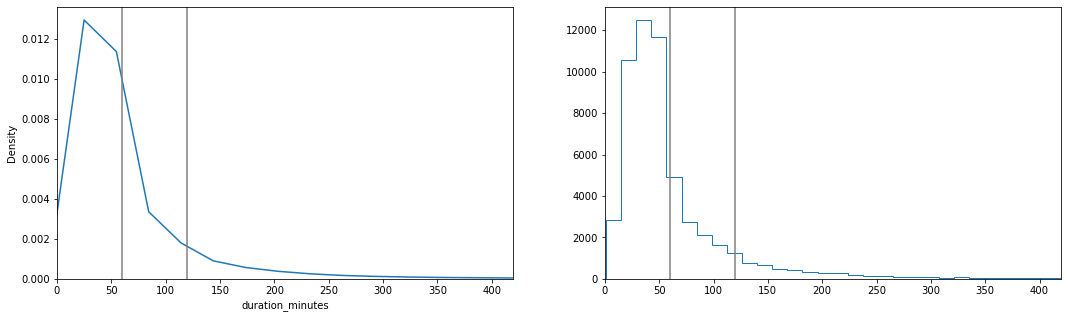

In [4]:
xmax  = 420

fig, axs = plt.subplots(1,2,figsize=(18,5))
sns.kdeplot(data.duration_minutes, ax = axs[0])
axs[0].axvline(60, color  = 'grey')
axs[0].axvline(120, color  = 'grey')
axs[0].set_xlim(0,xmax)

axs[1].hist(data.duration_minutes, histtype = 'step', bins = xmax)
axs[1].axvline(60, color  = 'grey')
axs[1].axvline(120, color  = 'grey')
axs[1].set_xlim(0,xmax)

## estimation

In [13]:
# bunching at x = 60
bsize = 3
ex_reg = 5
z = 60
z_lower60 = z - ex_reg * bsize
missing60 = z + ex_reg * bsize

bunch60 = tools.bunching(data.duration_minutes, bsize = bsize, xmax= 90, xmin= 0, z_upper= z, z_lower= z_lower60, missing = missing60, ex_reg= ex_reg, poly_dgr=6)
#print(bunch60.df_count())

display(bunch60.estimation_res())

print('deltaX:', bunch60.get_deltaX(), 'mX:', bunch60.get_mX())

pred60 = bunch60.prediction()

print('total bunching',bunch60.total_bunch())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nobs   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     106.8
Date:                Fri, 10 Sep 2021   Prob (F-statistic):           2.96e-15
Time:                        17:07:09   Log-Likelihood:                -192.54
No. Observations:                  30   AIC:                             403.1
Df Residuals:                      21   BIC:                             415.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     68.3599    161.219      0.424      0.676    -266.914     403.634
duration      25.4554     58.074      0.438      0.666     -95.317     146.228
duration2     10.3589      6.365      1.627      0.119      -2.878      23.596
duration3     -0.3965      0.288     -1.378      0.183      -0.995       0.202
duration4      0.0045      0.006      0.733      0.471      -0.008       0.017
duration5  -1.067e-05   6.23e-05     -0.171      0.866      -0.000       0.000
duration6  -5.804e-08   2.39e-07     -0.243      0.810   -5.55e-07    4.39e-07
b            661.2316    187.534      3.526      0.002     271.234    1051.229
m            146.8296    206.826      0.710      0.486    -283.288     576.947
==============================================================================
Omnibus:                       14.896   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               37.930
Skew:                          -0.704   Prob(JB):                     5.80e-09
Kurtosis:                       8.326   Cond. No.                     1.05e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

deltaX: 7.657848836057477 mX: 4.0863589862010565
total bunching 38.49501624877378


In [14]:
# bunching at x = 120
bsize = 3
ex_reg = 2
z = 120
z_lower120 = z - ex_reg * bsize
missing120 = z + ex_reg * bsize

# define bins

bunch120 = tools.bunching(data.duration_minutes, bsize = bsize, xmax= 160, xmin= 90, z_upper= z, z_lower= z_lower120, missing = missing120, ex_reg= ex_reg, poly_dgr=6, include_missing=False)
#print(bunch120.df_count())

display(bunch120.estimation_res())

print('deltaX:', bunch120.get_deltaX())

pred120 = bunch120.prediction()

print('total bunching',bunch120.total_bunch())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nobs   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     124.3
Date:                Fri, 10 Sep 2021   Prob (F-statistic):           2.64e-13
Time:                        17:07:55   Log-Likelihood:                -105.25
No. Observations:                  24   AIC:                             222.5
Df Residuals:                      18   BIC:                             229.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6344     27.728      0.059      0.954     -56.620      59.888
duration      32.6986    554.691      0.059      0.954   -1132.664    1198.061
duration2     -1.2824     22.897     -0.056      0.956     -49.387      46.823
duration3      0.0295      0.374      0.079      0.938      -0.757       0.816
duration4     -0.0003      0.003     -0.114      0.910      -0.007       0.006
duration5     1.9e-06   1.21e-05      0.157      0.877   -2.36e-05    2.74e-05
duration6  -3.887e-09   1.93e-08     -0.201      0.843   -4.44e-08    3.67e-08
b             49.4512     18.361      2.693      0.015      10.876      88.027
==============================================================================
Omnibus:                        6.339   Durbin-Watson:                   2.324
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                6.593
Skew:                          -0.263   Prob(JB):                       0.0370
Kurtosis:                       5.513   Cond. No.                     6.15e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.15e+17. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

deltaX: 1.2248710410745163
total bunching 0.54457938772066


Text(0.5, 0, 'Duration (Minutes)')

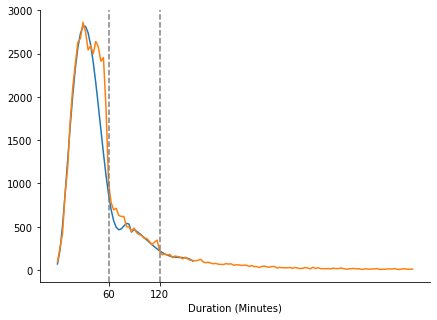

In [35]:
# concat the two predictions
pred = pd.concat([pred60,pred120], ignore_index=True)
xs = tools.bunching(data.duration_minutes, bsize = bsize, xmax= xmax, xmin= 0, z_upper= z, z_lower= z_lower120, missing = missing120, ex_reg= ex_reg, poly_dgr=6, include_missing=False).df_count()


fig, ax = plt.subplots(figsize=(7,5))
plt.plot(pred.duration, pred.y_pred)
plt.plot(xs.duration, xs.nobs)
plt.axvline(60, color= 'grey', linestyle = 'dashed')
plt.axvline(120, color= 'grey', linestyle = 'dashed')
plt.xticks(ticks = [60, 120])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Duration (Minutes)')

In [8]:
### solve for alpha
a = symbols('a')
delta_x = bunch60.get_deltaX()
def sigmaI(a):
    return (60 + delta_x)*(pi)**(1/(1+a))

def  xI(a):
    return  sigmaI(a) * (pi+phi)**(-1/(1+a))

def L(a):
    return tools.K(xI(a), sigmaI(a), pi=pi, phi=phi, phi120 = phi,alpha=a)
    

def R(a):
    return pi*60 + tools.C(60, sigmaI(a), a) 

def solution(a):
    return L(a) - R(a)
res = fsolve(solution, 1)
print(res)

[13.97780447]
